# Phase 3 Project Tanzanian Water Wells

## Binary Logistic regression Model

In [340]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_curve
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

In [431]:
tz_data = pd.read_csv('final_data/tz_data.csv')

In [432]:
data = tz_data.copy()
data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,payment_type,quality_group,quantity_group,source,waterpoint_type_group,status_group
0,69572,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,109,True,VWC,False,1999,gravity,annually,good,enough,spring,communal standpipe,2
1,8776,0.0,other,1399,other,34.698766,-2.147466,Lake Victoria,280,True,Other,True,2010,gravity,never pay,good,insufficient,rainwater harvesting,communal standpipe,2
2,34310,25.0,other,686,other,37.460664,-3.821329,Pangani,250,True,VWC,True,2009,gravity,per bucket,good,enough,dam,communal standpipe,2
3,67743,0.0,other,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,VWC,True,1986,submersible,never pay,good,dry,machine dbh,communal standpipe,0
4,19728,0.0,other,0,other,31.130847,-1.825359,Lake Victoria,0,True,VWC,True,2000,gravity,never pay,good,seasonal,rainwater harvesting,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,other,1210,other,37.169807,-3.253847,Pangani,125,True,Water Board,True,1999,gravity,per bucket,good,enough,spring,communal standpipe,2
59396,27263,4700.0,other,1212,other,35.249991,-9.070629,Rufiji,56,True,VWC,True,1996,gravity,annually,good,enough,river,communal standpipe,2
59397,37057,0.0,Government Of Tanzania,0,DWE,34.017087,-8.750434,Rufiji,0,True,VWC,False,2000,handpump,monthly,fluoride,enough,machine dbh,hand pump,2
59398,31282,0.0,other,0,other,35.861315,-6.378573,Rufiji,0,True,VWC,True,2000,handpump,never pay,good,insufficient,shallow well,hand pump,2


In [343]:
data = data.drop(['id','funder', 'amount_tsh'], axis =1) 

In [344]:
# Changing all T/F columns 
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

In [345]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             59400 non-null  int64  
 1   installer              59400 non-null  object 
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   population             59400 non-null  int64  
 6   public_meeting         59400 non-null  int64  
 7   scheme_management      59400 non-null  object 
 8   permit                 59400 non-null  int64  
 9   construction_year      59400 non-null  int64  
 10  extraction_type_class  59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source                 59400 non-null  object 
 15  wa

# Target
>- 0 = Non-functional
>- 1 = Functional but needs repair
>- 2 =  Functional
>- Assigning new values those that are functional water pums as 1 and non functioning as zero

In [346]:
target_status = {0:0, 1: 1, 2 : 1}
data['status_group'] = data['status_group'].replace(target_status)

In [347]:
data['status_group'].value_counts()

status_group
1    36576
0    22824
Name: count, dtype: int64

In [348]:
from datetime import datetime
data['age_of_well']=datetime.now().year - data['construction_year']

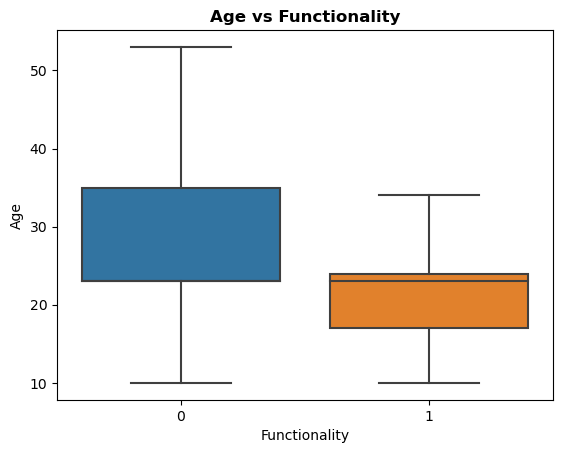

In [349]:
sns.boxplot(x='status_group',y='age_of_well', data=data, showfliers=False)
plt.xlabel('Functionality');
plt.ylabel('Age');
plt.title('Age vs Functionality',fontsize=12, fontweight='bold');

In [350]:
X = data.drop('status_group', axis=1)  
y = data['status_group']

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Processing 
>- setting the columns based on their features for pipeline modeling

In [352]:
cat_cols = ['installer', 'basin', 'scheme_management', 'extraction_type_class', 'payment_type', 'quality_group', 
              'quantity_group', 'source', 'waterpoint_type_group']

num_cols = ['gps_height', 'longitude', 'latitude','population', 'construction_year']
bin_cols = ['permit', 'public_meeting']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
    
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures(2)),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent'))
])

In [353]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols),
        ('bins',binary_transformer, bin_cols)
    ])

# Dummy model

In [354]:
Dummy_model = Pipeline(steps=[
    ('processes', preprocessor),
    ('classifier',DummyRegressor())
])

In [355]:
Dummy_model.fit(X_train, y_train)

Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['installer', 'basin',
                                                   'scheme_management',
                                                   'extraction_type_class',
                                                   'payment_type',
                                                   'quality_group',
                                                   'quantity_group', 'source',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'population',
                                                   'construction_year']),
                                                 ('bins',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])])),
                ('classifier', DummyRegressor())])

In [356]:
Dummy_model.score(X_train, y_train)

0.0

In [357]:
Dummy_model.score(X_test, y_test)

-0.00013439718533914125

## Logistic Regression

In [358]:
Model = Pipeline(steps=[
    ('processes', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced', random_state =42))
])

In [359]:
Model.fit(X_train, y_train)

Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['installer', 'basin',
                                                   'scheme_management',
                                                   'extraction_type_class',
                                                   'payment_type',
                                                   'quality_group',
                                                   'quantity_group', 'source',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   Si...gy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'population',
                                                   'construction_year']),
                                                 ('bins',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=42))])

In [360]:
Model.score(X_train, y_train)

0.7837831046786271

In [361]:
Model.score(X_test, y_test)

0.7843077237016631

In [362]:
y_pred_fsm = Model.predict(X_test)

In [363]:
y_train_pred = Model.predict(X_train)
y_test_pred = Model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7837831046786271
Test Accuracy: 0.7843077237016631

Balanced Accuracy:
Train Accuracy: 0.7639978435793361
Test Accuracy: 0.763913058052631


              precision    recall  f1-score   support

           0       0.69      0.70      0.69      7458
           1       0.81      0.80      0.81     12144

    accuracy                           0.76     19602
   macro avg       0.75      0.75      0.75     19602
weighted avg       0.77      0.76      0.76     19602



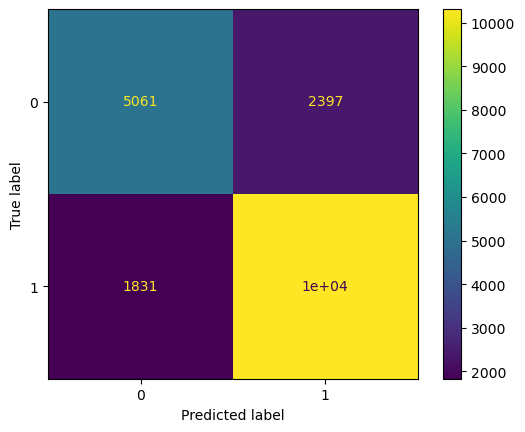

In [364]:
print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [365]:
from sklearn.metrics import log_loss

y_train_pred_proba = Model.predict_proba(X_train)
y_test_pred_proba = Model.predict_proba(X_test)

train_log_loss = log_loss(y_train, y_train_pred_proba)
print("Train Log Loss:", train_log_loss)

test_log_loss = log_loss(y_test, y_test_pred_proba)
print("Test Log Loss:", test_log_loss)

Train Log Loss: 0.4730369874031949
Test Log Loss: 0.4732539765062816


Text(0.5, 0, 'False Positive Rate')

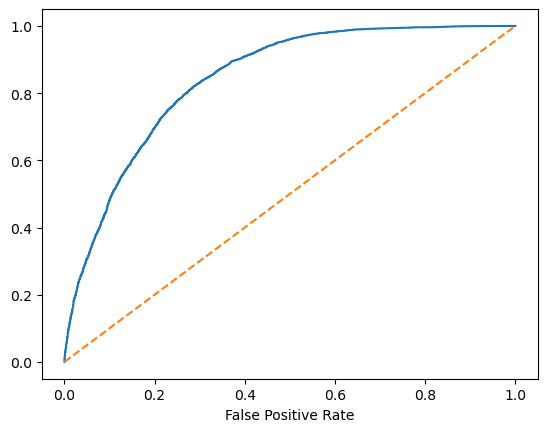

In [366]:
probs = Model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

# Grid Search 

In [367]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver':['lbfgs', 'liblinear'],
    'classifier__max_iter': [100, 1000, 10000],  
}

In [368]:
grid_search = GridSearchCV(Model, param_grid, cv= 5, verbose = 2, n_jobs=-1)

In [369]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['installer',
                                                                          'basin',
                                                                          'scheme_management',
                                                                          'extraction_type_class',
                                                                          'payment_type',
                                                                          'quality_group',
                                                                          'quantity_group',
                                                                          'source',
                                                                          'waterpoint_type_group']),
                                                                        ('num',
                                                                         P...
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['permit',
                                                                          'public_meeting'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__max_iter': [100, 1000, 10000],
                         'classifier__penalty': ['l2', 'l1'],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             verbose=2)

In [370]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("best_params:", best_params)

best_params: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [371]:
y_pred_gr = best_model.predict(X_test)

In [372]:
import numpy as np

unique_values = np.unique(y_train)
print(unique_values)

[0 1]


In [373]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [374]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.784109754259008
Test Accuracy: 0.7844097541067238

Balanced Accuracy:
Train Accuracy: 0.7641914416591423
Test Accuracy: 0.7638143166952325


In [424]:
data_results = pd.DataFrame(columns=["Model", "test_balanced_acc",
                                   'train_balanced_acc', 'info'])

In [425]:
results_1 = pd.DataFrame({       
     "Model": ['Dummyreggressor'],
      "test_balanced_acc": [0.5], 
       'train_balanced_acc' : [0.5],
               'info' : ['baseline']
})
data_results = pd.concat([data_results, results_1], ignore_index =True)

In [426]:
results_2 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.738], 
       'train_balanced_acc' : [0.737],
               'info' : ['fsm_pipeline'],
})
data_results = pd.concat([data_results, results_2], ignore_index =True)

In [427]:
results_3 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.765], 
       'train_balanced_acc' : [0.764],
               'info' : ['without funder and tsh_amount'],
})
data_results = pd.concat([data_results, results_3], ignore_index =True)

In [428]:
results_4 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.763], 
       'train_balanced_acc' : [0.76],
               'info' : ['grid search, best_params'],
})
data_results = pd.concat([data_results, results_4], ignore_index =True)

In [429]:
results_5 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.763], 
       'train_balanced_acc' : [0.763],
               'info' : ['SMOTE, best_params'],
})
data_results = pd.concat([data_results, results_5], ignore_index =True)

              precision    recall  f1-score   support

           0       0.69      0.70      0.69      7458
           1       0.81      0.80      0.81     12144

    accuracy                           0.76     19602
   macro avg       0.75      0.75      0.75     19602
weighted avg       0.77      0.76      0.76     19602



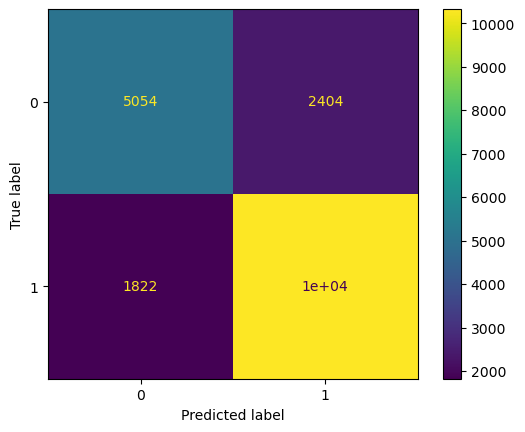

In [382]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

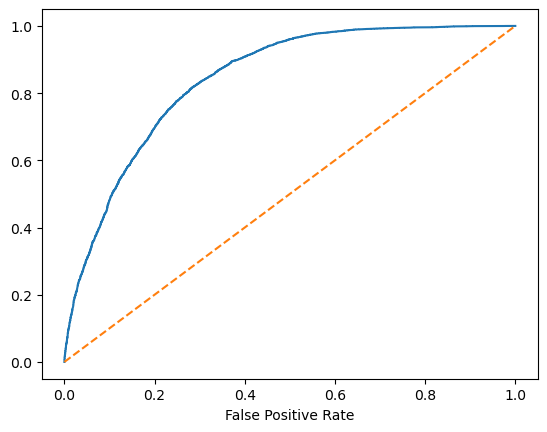

In [383]:
probs = best_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

# Logistic regression With SMOTE
>- model performed well on training and the test, but the balanced accuracy is much lower meaning there's huge class imbalance
>- Below is the model with SMOTE

In [384]:
Smote_model = ImPipeline(steps=[
    ('processes', preprocessor),
    ('sm', SMOTE(random_state = 42, n_jobs =-1)),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced', random_state =42))
])

In [385]:
best_param = {
    'classifier__C': [0.1],
    'classifier__penalty': ['l2'],
    'classifier__solver':['liblinear'],
    'classifier__max_iter': [100],  
}

In [386]:
grid_search_smote = GridSearchCV(Smote_model, best_param, cv= 5, verbose = 2, n_jobs=-1)

In [387]:
grid_search_smote.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['installer',
                                                                          'basin',
                                                                          'scheme_management',
                                                                          'extraction_type_class',
                                                                          'payment_type',
                                                                          'quality_group',
                                                                          'quantity_group',
                                                                          'source',
                                                                          'waterpoint_type_group']),
                                                                        ('num',
                                                                         P...
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['permit',
                                                                          'public_meeting'])])),
                                       ('sm',
                                        SMOTE(n_jobs=-1, random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1], 'classifier__max_iter': [100],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['liblinear']},
             verbose=2)

In [388]:
best_model_smote = grid_search_smote.best_estimator_

In [389]:
y_pred = best_model_smote.predict(X_test)

In [390]:
y_train_pred = best_model_smote.predict(X_train)
y_test_pred = best_model_smote.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7845117845117845
Test Accuracy: 0.7848178757269666

Balanced Accuracy:
Train Accuracy: 0.7638910118325689
Test Accuracy: 0.7637556548555972


In [391]:
prediction_df = pd.DataFrame({'Predicted':y_pred})

In [409]:
prediction_df

,Predicted
0,0
1,1
2,1
3,0
4,1
...,...
19597,1
19598,0
19599,1
19600,1


In [430]:
data_results

,Model,test_balanced_acc,train_balanced_acc,info
0,Dummyreggressor,0.500,0.500,baseline
1,LogisticRegression,0.738,0.737,fsm_pipeline
2,LogisticRegression,0.765,0.764,without funder and tsh_amount
3,LogisticRegression,0.763,0.760,"grid search, best_params"
4,LogisticRegression,0.763,0.763,"SMOTE, best_params"


In [402]:
categorical_cols = ['installer', 'basin', 'scheme_management', 'extraction_type_class', 'payment_type', 'quality_group', 
              'quantity_group', 'source', 'waterpoint_type_group']

numeric_cols = ['gps_height', 'longitude', 'latitude','population', 'construction_year']
binary_cols = ['permit', 'public_meeting']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())  
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures(2)),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent'))
])

In [403]:
CT = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numeric_cols),
        ('bins',binary_transformer, binary_cols)
    ])

In [404]:
Multiclass_Model = Pipeline(steps=[
    ('processes', CT),
    ('classifier', LogisticRegression(solver='lbfgs', class_weight='balanced', random_state =42))
])

In [407]:
multiclass_param = {
    'classifier__C': [0.1],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver':['liblinear', 'lbfgs'],
    'classifier__class_weight': ['balanced'],
    'classifier__max_iter': [100, 1000, 10000],
    
}

In [408]:
grid_search_multiclass = GridSearchCV(Model, param_grid, cv= 5, verbose = 2, n_jobs=-1)
grid_search_multiclass.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['installer',
                                                                          'basin',
                                                                          'scheme_management',
                                                                          'extraction_type_class',
                                                                          'payment_type',
                                                                          'quality_group',
                                                                          'quantity_group',
                                                                          'source',
                                                                          'waterpoint_type_group']),
                                                                        ('num',
                                                                         P...
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['permit',
                                                                          'public_meeting'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__max_iter': [100, 1000, 10000],
                         'classifier__penalty': ['l2', 'l1'],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             verbose=2)

In [421]:
best_model_m = grid_search_multiclass.best_estimator_
best_params_m = grid_search_multiclass.best_params_
y_pred_multiclass = grid_search_multiclass.predict(X_test)
y_pred_multiclass

array([0, 1, 1, ..., 1, 1, 1])

In [422]:
y_train_pred = best_model_m.predict(X_train_m)
y_test_pred = best_model_m.predict(X_test_m)

print("Accuracy:")
train_accuracy = accuracy_score(y_train_m, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test_m, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train_m, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test_m, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.3192874013769536
Test Accuracy: 0.315273951637588

Balanced Accuracy:
Train Accuracy: 0.4916058319917031
Test Accuracy: 0.48927900335445745
